#                                                        INTRODUCTION  
New York City’s demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

As we know New York is the port of entry for those who come with dreams it is one of the most densly populated immigrant residential areas.There are 800 languages spoken in New York, making it the most linguistically diverse city in the world.

With it’s diverse culture , comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualise all major parts of New York City that has great Indian restaurants.

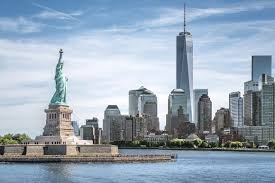

# BUSINESS PROBLEM
Our goal of this project will be to analyze and identify the best location in New York to open an Indian Restaurants or finding a best place in New York if you want to enjoy the food in great Indian restaurants.

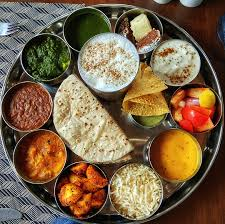

# Data
The following data will be used for this project :



New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude

Data source : https://cocl.us/new_york_dataset 

Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
Indian resturants in each neighborhood of new york city.

Data source : Fousquare API

Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
GeoSpace data

Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

# Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Indian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

# Questions to be asked

1 What is best location in New York City for Indian Cuisine ?

2 Which areas have potential Indian Resturant Market ?

3 Which all areas lack Indian Resturants ?

4 Which is the best place to stay if I prefer Indian Cuisine ?

# Libraries
We will import the required libraries for python.



1 pandas and numpy for handling data.

2 request module for using FourSquare API.

3 geopy to get co-ordinates of City of New York.

4 folium to visualize the results on a map

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: \ ^C
| Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [42]:
CLIENT_ID = 'MLKHIB0WUP30MCK3ZG5FJ5YJS3JJUMOTQIWECVGU1IAX0LEO' # your Foursquare ID
CLIENT_SECRET = 'PMTN1UYO31UR5AIHLLRL52NHEGSHTWZF4GFWDSWOOGFS0LHM' # your Foursquare Secret
VERSION = '20200810' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MLKHIB0WUP30MCK3ZG5FJ5YJS3JJUMOTQIWECVGU1IAX0LEO
CLIENT_SECRET:PMTN1UYO31UR5AIHLLRL52NHEGSHTWZF4GFWDSWOOGFS0LHM


In [43]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [44]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.



In [15]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

Total number of neighborhoods in NewYork = 306

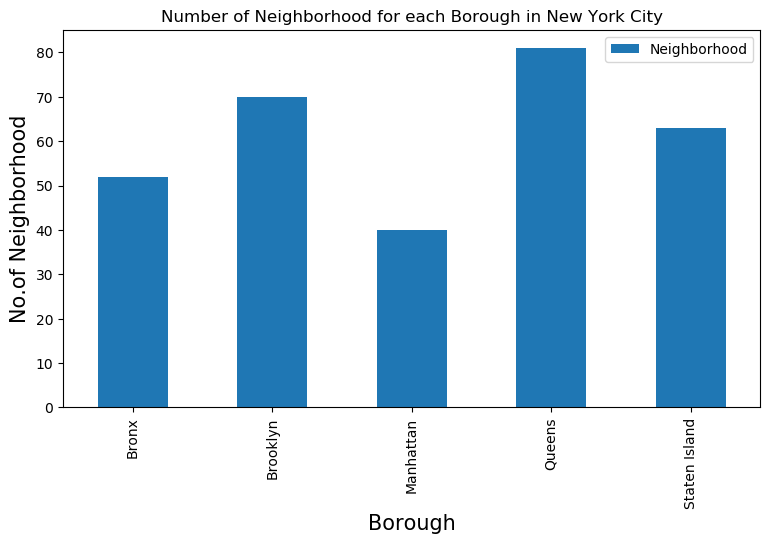

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see Queens has the highest number of neighborhood and Manhattan has the lowest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [45]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:0
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:1
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

Now that we have got all the indian resturants in new york city , we will analyze it

In [46]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights


In [47]:
indian_rest_ny.shape

(40, 4)

We got 40 Indian Resturants across New York City

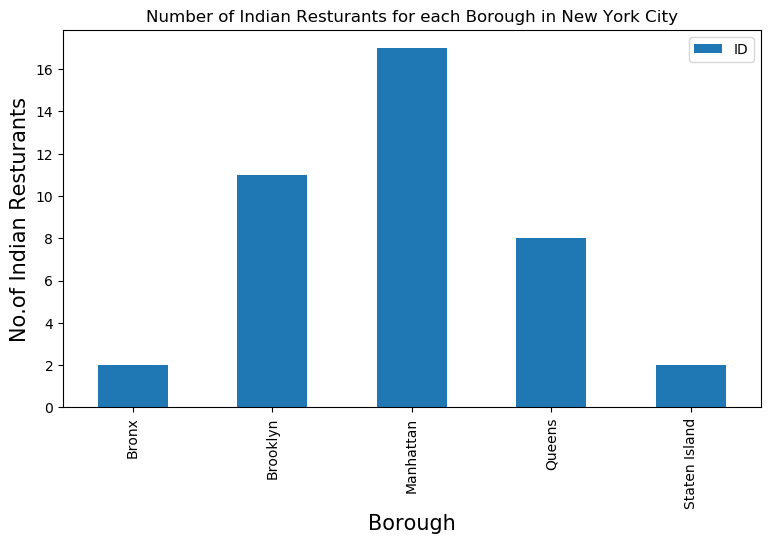

In [48]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan has the largest number of indian resturants

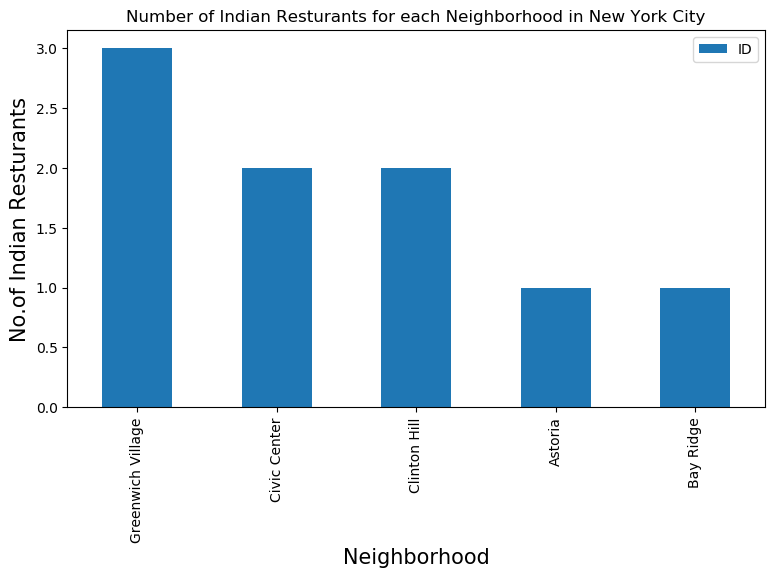

In [53]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [113]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

,Borough,Neighborhood,ID,Name
19,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda
20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company
21,Manhattan,Greenwich Village,4d992c1e942ba093ebb5968c,THELEwala


In [60]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5f30cb7bc9c6b914fd05d884'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5f30cd53b0029033bd87aa96'}, 'response': {'venue': {'id': '4c194631838020a13e78e561', 'name': 'Melanies Roti Bar And Grill', 'contact': {'phone': '7184091088', 'formattedPhone': '(718) 409-1088'}, 'location': {'address': '1248 Castle Hill Ave', 'crossStreet': 'Newbold Ave', 'lat': 40.833293, 'lng': -73.85104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833293, 'lng': -73.85104}, {'label': 'entrance', 'lat': 40.833276, 'lng': -73.851166}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1248 Castle Hill Ave (Newbold Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/melanies-roti-bar-and-grill/4c194631838020a13e78e561', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5f30cc3c82da01237e6a93ba'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5f30cd07acc11570bee21545'}, 'response': {'venue': {'id': '4b8ffc16f964a520246e33e3', 'name': 'Curry Heights', 'contact': {'phone': '7182609000', 'formattedPhone': '(718) 260-9000', 'twitter': 'curryheights'}, 'location': {'address': '151 Remsen St', 'crossStreet': 'btwn Court St & Clinton St', 'lat': 40.69357223828141, 'lng': -73.99226545349896, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69357223828141, 'lng': -73.99226545349896}, {'label': 'entrance', 'lat': 40.693578, 'lng': -73.992235}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Remsen St (btwn Court St & Clinton St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-heights/4b8ffc16f964a520246e33e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5f30cc7f9ed85e68a2209c2c'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

{'meta': {'code': 200, 'requestId': '5f30cc85cf2d854abdd0790b'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5f30cca3e48ac773fabd758c'}, 'response': {'venue': {'id': '4ace7c86f964a520d3d020e3', 'name': "Kinara's", 'contact': {'phone': '7182374008', 'formattedPhone': '(718) 237-4008'}, 'location': {'address': '368 Myrtle Ave', 'crossStreet': 'Adelphi Street', 'lat': 40.69322031901606, 'lng': -73.97142314141769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69322031901606, 'lng': -73.97142314141769}, {'label': 'entrance', 'lat': 40.693105, 'lng': -73.971458}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['368 Myrtle Ave (Adelphi Street)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kinaras/4ace7c86f964a520d3d020e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5f30cad403cd7d164b71a444'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '5f30cc0ef39d6963a401dc3c'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5f30ccf4c5ebcc30c4b4742d'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5f30ccca2f553b562318dda4'}, 'response': {'venue': {'id': '49d91c12f964a520015e1fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2127304280', 'formattedPhone': '(212) 730-4280', 'twitter': 'katirollcompany'}, 'location': {'address': '49 W 39th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.75265571457166, 'lng': -73.98477837472183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75265571457166, 'lng': -73.98477837472183}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 W 39th St (btwn 5th & 6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/49d91c12f964a520015e1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5f30cc970570a56adcc3c0f7'}, 'response': {'venue': {'id': '56c931b2cd10407d3ecbefda', 'name': 'Ananda', 'contact': {}, 'location': {'address': '210 Thompson St', 'crossStreet': 'btwn W 3rd & Bleecker Sts', 'lat': 40.72883889496238, 'lng': -73.9993364782382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72883889496238, 'lng': -73.9993364782382}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 Thompson St (btwn W 3rd & Bleecker Sts)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ananda/56c931b2cd10407d3ecbefda', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'url': 'http://www.ahimsa.nyc', '

{'meta': {'code': 200, 'requestId': '5f30cc76dd2e0829bb32c759'}, 'response': {'venue': {'id': '4593ed04f964a52050401fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2124206517', 'formattedPhone': '(212) 420-6517'}, 'location': {'address': '99 Macdougal St', 'crossStreet': 'btwn Bleecker & W 3rd St', 'lat': 40.7295697222648, 'lng': -74.00086061309852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7295697222648, 'lng': -74.00086061309852}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Macdougal St (btwn Bleecker & W 3rd St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/4593ed04f964a52050401fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5f30cd0bacc11570bee21f16'}, 'response': {'venue': {'id': '4bbb9dbded7776b0e1ad3e51', 'name': 'Tamarind TriBeCa', 'contact': {'phone': '2127759000', 'formattedPhone': '(212) 775-9000', 'facebook': '201503306550753', 'facebookName': 'Tamarind Tribeca'}, 'location': {'address': '99 Hudson St', 'crossStreet': 'at Franklin St', 'lat': 40.71921117375622, 'lng': -74.00872657957527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71921117375622, 'lng': -74.00872657957527}, {'label': 'entrance', 'lat': 40.719084, 'lng': -74.008899}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Hudson St (at Franklin St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tamarind-tribeca/4bbb9dbded7776b0e1ad3e51', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5f30cc8b2bbd331380922e38'}, 'response': {'venue': {'id': '4d24b812836f5481518645f7', 'name': 'Doaba Deli', 'contact': {'phone': '2122222636', 'formattedPhone': '(212) 222-2636'}, 'location': {'address': '945 Columbus Ave', 'crossStreet': 'btw W 106th & 107th', 'lat': 40.799513471286254, 'lng': -73.96266286944638, 'labeledLatLngs': [{'label': 'display', 'lat': 40.799513471286254, 'lng': -73.96266286944638}], 'postalCode': '10025', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['945 Columbus Ave (btw W 106th & 107th)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/doaba-deli/4d24b812836f5481518645f7', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5f30cca188d9f22c7adc52ab'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5f30cac151e46d2576134d13'}, 'response': {'venue': {'id': '4b3a8aa5f964a520996925e3', 'name': 'Sajni 026', 'contact': {'phone': '7182750606', 'formattedPhone': '(718) 275-0606'}, 'location': {'address': '9810 Queens Blvd', 'crossStreet': '65th Rd.', 'lat': 40.728123, 'lng': -73.858071, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728123, 'lng': -73.858071}, {'label': 'entrance', 'lat': 40.728194, 'lng': -73.85792}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9810 Queens Blvd (65th Rd.)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sajni-026/4b3a8aa5f964a520996925e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '5f30cd5e587145663914ea85'}, 'response': {'venue': {'id': '541e183b498e7ff705405a60', 'name': 'Ganpati Rasoi', 'contact': {}, 'location': {'lat': 40.751904, 'lng': -73.854249, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751904, 'lng': -73.854249}], 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Queens, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ganpati-rasoi/541e183b498e7ff705405a60', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 

{'meta': {'code': 200, 'requestId': '5f30cde786af526945b4e4fc'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '5f30cc13f7e86f7793e1ded7'}, 'response': {'venue': {'id': '50b02338e4b047828b2277c1', 'name': 'Benares', 'contact': {'phone': '2129670400', 'formattedPhone': '(212) 967-0400'}, 'location': {'address': '45 Murray St', 'crossStreet': 'Park Place', 'lat': 40.714117, 'lng': -74.009248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714117, 'lng': -74.009248}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Murray St (Park Place)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/benares/50b02338e4b047828b2277c1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 44}, 'url': 'http://www.benaresnyc.com', 'pri

{'meta': {'code': 200, 'requestId': '5f30cb0bd333b03b33d85aef'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

( 39 / 40 ) processed
{'meta': {'code': 200, 'requestId': '5f30cb0bd333b03b33d85bc7'}, 'response': {'venue': {'id': '4c48da9f3013a59356c5f0e1', 'name': 'Saffron Garden', 'contact': {'phone': '7184334449', 'formattedPhone': '(718) 433-4449'}, 'location': {'address': '46-11 Skillman Ave', 'crossStreet': 'btwn 46th and 47th', 'lat': 40.74655397129589, 'lng': -73.9177381667934, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74655397129589, 'lng': -73.9177381667934}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-11 Skillman Ave (btwn 46th and 47th)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saffron-garden/4c48da9f3013a59356c5f0e1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary'

In [62]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,34,7.2,16
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,12,5.6,5


In [63]:
indian_rest_stats_ny.shape

(40, 7)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [64]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [65]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [66]:
indian_rest_stats_ny_csv.shape

(40, 7)

In [67]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,34,7.2,16
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,12,5.6,5


In [68]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null object
Rating          40 non-null float64
Tips            40 non-null object
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [69]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [70]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [71]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null float64
Rating          40 non-null float64
Tips            40 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


Now the data types looks correct

In [72]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.4
Tips                                 256
Name: 17, dtype: object

In [73]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                598
Rating                               9.1
Tips                                 148
Name: 22, dtype: object

In [74]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.4
Tips                                 256
Name: 17, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [75]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [76]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Tribeca,9.1
23,Noho,8.8
11,Fort Greene,8.8
26,Prospect Lefferts Gardens,8.7
8,Chelsea,8.7
14,Greenwich Village,8.6
25,North Side,8.5
34,West Village,8.5
21,Midtown,8.4
0,Astoria,8.4


Above are the top neighborhoods with top average rating of Indian resturants

In [77]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [78]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.241176
1,Brooklyn,7.427273
0,Bronx,7.000000
3,Queens,6.637500
4,Staten Island,4.100000


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

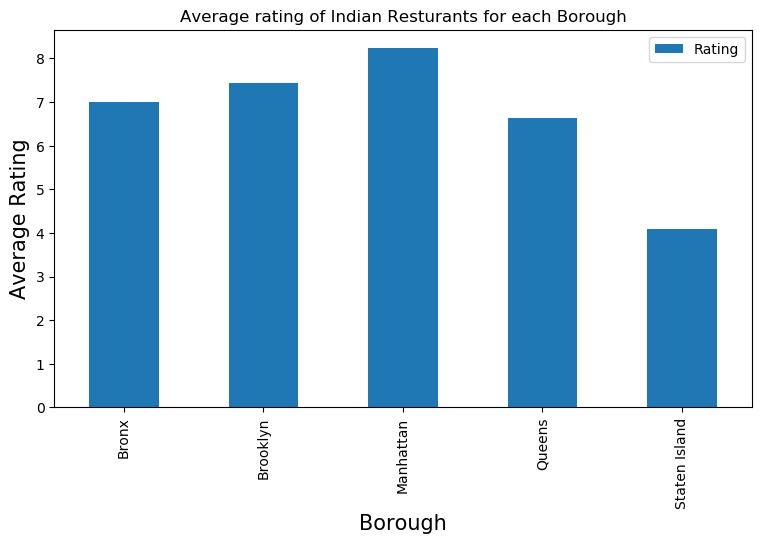

In [79]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with highest rating 

In [115]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Tribeca,9.1
23,Noho,8.8
11,Fort Greene,8.8
26,Prospect Lefferts Gardens,8.7
8,Chelsea,8.7
14,Greenwich Village,8.6
25,North Side,8.5
34,West Village,8.5
21,Midtown,8.4
0,Astoria,8.4


These are  average ratings of Indian Restaurants for each Borough

In [117]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.241176
1,Brooklyn,7.427273
0,Bronx,7.000000
3,Queens,6.637500
4,Staten Island,4.100000


We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [118]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.4
2,Bayside,8.4
6,Carnegie Hill,8.1
8,Chelsea,8.7
11,Fort Greene,8.8
14,Greenwich Village,8.6
17,Kew Gardens,8.0
21,Midtown,8.4
22,New Dorp,8.2
23,Noho,8.8


We will join this Dataset to original New York data to get longitude and latitude

In [120]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.4
1,Queens,Bayside,40.766041,-73.774274,8.4
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.1
3,Manhattan,Chelsea,40.744035,-74.003116,8.7
4,Staten Island,Chelsea,40.594726,-74.189560,8.7
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.8
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.6
7,Queens,Kew Gardens,40.705179,-73.829819,8.0
8,Manhattan,Midtown,40.754691,-73.981669,8.4
9,Staten Island,New Dorp,40.572572,-74.116479,8.2


Now we will show this data on a map

In [94]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [95]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [96]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [97]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion
Manhattan and Brooklyn have the best rated Indian restaurants on average. Staten Island and The Queens have the least amount of Indian restaurants per borough. However, of note, Greenwich village in Manhattan has the highest number of Indian Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Indian restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open an Indian restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to THE KATI ROLL COMPANY in Manhattan for the best Indian food based on 832 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
